# Tensorflow Implementation of VGG Face Detector

Objective: Convert the VGG face descriptor model http://www.robots.ox.ac.uk/~vgg/software/vgg_face/ to Tensorflow format.
<br>
Output: Final Tensorflow classifier model trained on the gender dataset

In [1]:
import scipy.io as sio
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Convolution2D, MaxPooling2D, Dense, Dropout, Softmax, Flatten, Activation, BatchNormalization

Using TensorFlow backend.


## Read .mat file for Model Description

In [2]:
def load_mat():
    mat = sio.loadmat('data/vgg_face.mat', struct_as_record=False)
    return mat

mat = load_mat()
net = mat['net'][0][0]
mat_model = net.layers
mat_model_layers = mat_model[0]
num_mat_layers = mat_model_layers.shape[0]
for layer in mat_model_layers:
    print(layer[0][0].name)

['conv1_1']
['relu1_1']
['conv1_2']
['relu1_2']
['pool1']
['conv2_1']
['relu2_1']
['conv2_2']
['relu2_2']
['pool2']
['conv3_1']
['relu3_1']
['conv3_2']
['relu3_2']
['conv3_3']
['relu3_3']
['pool3']
['conv4_1']
['relu4_1']
['conv4_2']
['relu4_2']
['conv4_3']
['relu4_3']
['pool4']
['conv5_1']
['relu5_1']
['conv5_2']
['relu5_2']
['conv5_3']
['relu5_3']
['pool5']
['fc6']
['relu6']
['dropout6']
['fc7']
['relu7']
['dropout7']
['fc8']
['softmax']


## VGG Architecture Implementation
We can read the model described in the .mat file and build our tensorflow/keras model using clues. This way we can avoid reproducing it by hand. Additionally, this saves us the trouble of later applying the model weights from the .mat file to our tensorflow/keras model.

In [3]:
def vgg_tf():
    model = Sequential()

    for i in range(num_mat_layers):
        mat_model_layer = mat_model_layers[i][0][0].name[0]
        if mat_model_layer.find("conv") == 0 or mat_model_layer.find("fc") == 0:
            weights = mat_model_layers[i][0,0].weights
            weights_shape = weights[0][0].shape
            filter_x = weights_shape[0]; filter_y = weights_shape[1]
            number_of_filters = weights_shape[3]

            if mat_model_layer.find("conv") == 0:
                print("ZeroPadding2D((1,1))")
                if i == 0:
                    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
                else:
                    model.add(ZeroPadding2D((1,1)))

            print("Convolution2D(",number_of_filters,", (",filter_x,", ",filter_y,"), name='",mat_model_layer,"')")
            model.add(Convolution2D(number_of_filters, (filter_x, filter_y), name= mat_model_layer))

        else:
            if mat_model_layer.find("relu") == 0:
                print("Activation('relu', name=",mat_model_layer)
                model.add(Activation('relu', name=mat_model_layer))
            elif mat_model_layer.find("dropout") == 0:
                print("Dropout(0.5, name=",mat_model_layer,")")
                model.add(Dropout(0.5, name=mat_model_layer))
            elif mat_model_layer.find("pool") == 0:
                print("MaxPooling2D((2,2), strides=(2,2), name=",mat_model_layer,")")
                model.add(MaxPooling2D((2,2), strides=(2,2), name=mat_model_layer))
            elif mat_model_layer.find("softmax") == 0:
                print("Activation('softmax', name=",mat_model_layer,")")
                model.add(Activation('softmax', name=mat_model_layer))
            else:
                print("-->",mat_model_layer)
    return model

Save model to .h5 file for use later.

In [4]:
model_ = vgg_tf()
model_.save('data/vgg_face.h5')
model = Model(inputs=model_.layers[0].input,outputs=model_.layers[-2].output)

ZeroPadding2D((1,1))
Convolution2D( 64 , ( 3 ,  3 ), name=' conv1_1 ')
Activation('relu', name= relu1_1
ZeroPadding2D((1,1))
Convolution2D( 64 , ( 3 ,  3 ), name=' conv1_2 ')
Activation('relu', name= relu1_2
MaxPooling2D((2,2), strides=(2,2), name= pool1 )
ZeroPadding2D((1,1))
Convolution2D( 128 , ( 3 ,  3 ), name=' conv2_1 ')
Activation('relu', name= relu2_1
ZeroPadding2D((1,1))
Convolution2D( 128 , ( 3 ,  3 ), name=' conv2_2 ')
Activation('relu', name= relu2_2
MaxPooling2D((2,2), strides=(2,2), name= pool2 )
ZeroPadding2D((1,1))
Convolution2D( 256 , ( 3 ,  3 ), name=' conv3_1 ')
Activation('relu', name= relu3_1
ZeroPadding2D((1,1))
Convolution2D( 256 , ( 3 ,  3 ), name=' conv3_2 ')
Activation('relu', name= relu3_2
ZeroPadding2D((1,1))
Convolution2D( 256 , ( 3 ,  3 ), name=' conv3_3 ')
Activation('relu', name= relu3_3
MaxPooling2D((2,2), strides=(2,2), name= pool3 )
ZeroPadding2D((1,1))
Convolution2D( 512 , ( 3 ,  3 ), name=' conv4_1 ')
Activation('relu', name= relu4_1
ZeroPadding2D((

## Load Dataset

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

In [6]:
def pad(img):
    ht, wd, cc= img.shape
    ww = 224
    hh = 224
    color = (0,0,0)
    result = np.full((hh,ww,cc), color, dtype=np.uint8)
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2
    result[yy:yy+ht, xx:xx+wd] = img
    return result

def load_img_file(path, model):
    img = Image.open(path)
#     img = load_img(path)
    x = img_to_array(img) 
    x = pad(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = model(x)
    return x

def load_data(path, model):
    x = []
    y = []
    labels = {}
    folders = os.listdir(path)
    for i in tqdm(range(len(folders))):
        labels[i] = folders[i]
        label_path = path + '/' + folders[i]
        images = os.listdir(label_path)
        for image in images:
            img = load_img_file(label_path + '/' + image, model)
            x.append(np.squeeze(K.eval(img)).tolist())
            y.append(i)
    return np.array(x), np.array(y), labels

In [7]:
X_train = y_train = labels = None
try:
    X_train = np.load('data/combined/X_train.npy', allow_pickle=True)
    y_train = np.load('data/combined/y_train.npy', allow_pickle=True)
    labels = np.load('data/combined/labels.npy', allow_pickle=True)[()]
except:
    X_train, y_train, labels = load_data('data/combined/aligned', model)
    np.save('data/combined/X_train', X_train)
    np.save('data/combined/y_train', y_train)
    np.save('data/combined/labels', labels)

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [05:59<00:00,  2.57s/it]


In [8]:
X_test = y_test = None
try:
    X_test = np.load('data/combined/X_test.npy', allow_pickle=True)
    y_test = np.load('data/combined/y_test.npy', allow_pickle=True)
    labels = np.load('data/combined/labels.npy', allow_pickle=True)[()]
except:
    X_test, y_test, labels = load_data('data/combined/valid', model)
    np.save('data/combined/X_test', X_test)
    np.save('data/combined/y_test', y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:47<00:00,  2.97it/s]


In [9]:
print(len(labels.keys()))

140


## Construct Classifier 

In [10]:
def classier_model(input_dim, num_classes):
    classifier = Sequential()
    classifier.add(Dense(num_classes))
    classifier.add(Activation('softmax'))
    classifier.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam', metrics=['accuracy'])
    return classifier

## Train Classifier

In [11]:
from matplotlib import pyplot as plt

def plotter(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Gender Classification
Train classifier for gender classification (of all ages together).

In [12]:
y_train_gender = y_train
y_test_gender = y_test
y_train_gender[y_train_gender % 2 == 0] = 0
y_train_gender[y_train_gender % 2 != 0] = 1
y_test_gender[y_test_gender % 2 == 0] = 0
y_test_gender[y_test_gender % 2 != 0] = 1

classifier = classier_model(2622, 2)
history = classifier.fit(X_train, y_train_gender, batch_size=16, epochs=100, validation_data=(X_test, y_test_gender))

Epoch 1/90
1840/1840 [==============================] - 3s 2ms/step - loss: 0.6523 - accuracy: 0.6181 - val_loss: 0.6194 - val_accuracy: 0.6764
Epoch 2/90
1840/1840 [==============================] - 3s 2ms/step - loss: 0.6073 - accuracy: 0.6780 - val_loss: 0.5868 - val_accuracy: 0.7044
Epoch 3/90
1840/1840 [==============================] - 3s 2ms/step - loss: 0.5833 - accuracy: 0.7011 - val_loss: 0.5808 - val_accuracy: 0.6919
Epoch 4/90
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5684 - accuracy: 0.7116 - val_loss: 0.5596 - val_accuracy: 0.7215
Epoch 5/90
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5567 - accuracy: 0.7212 - val_loss: 0.5592 - val_accuracy: 0.7104
Epoch 6/90
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5475 - accuracy: 0.7254 - val_loss: 0.5513 - val_accuracy: 0.7134
Epoch 7/90
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5403 - accuracy: 0.7338 - val_loss: 0.5336 - val_accuracy:

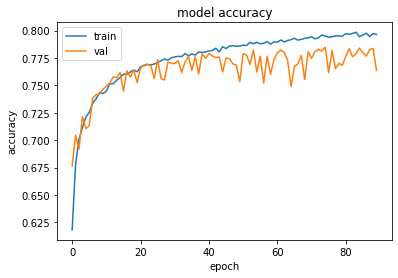

In [13]:
plotter(history)

### Age Group Classification
Train classifier to recognize the different age groups (not taking into account gender).

In [30]:
def labels(y):
    t = 0
    for i in range(0, 140, 2):
        bound = i + 2
        y[ y == i] = t
        y[ y == i+1 ] = t
        t += 1
    print(t)
    return y

y_train_age = labels(y_train)
y_test_age = labels(y_test)

classifier = classier_model(2622, 2)
history = classifier.fit(X_train, y_train_age, batch_size=16, epochs=100, validation_data=(X_test, y_test_age))

70
70
Epoch 1/100
 653/1840 [=========>....................] - ETA: 6s - loss: 0.0336 - accuracy: 0.9984

KeyboardInterrupt: 

In [ ]:
plotter(history)

### Gender and Age Group Classification
Train classifier to recognize gender across 7 different age groups (1-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61-70). Each age group has 2 genders.

In [ ]:
y_train_agegender = y_train
y_test_agegender = y_test

def age_gender_label(arr):
    i = 0
    while 

classifier = classier_model(2622, 2)
history = classifier.fit(X_train, y_train_agegender, batch_size=16, epochs=100, validation_data=(X_test, y_test_agegender))

Train classifier on all the classes.

In [ ]:
classifier = classier_model(2622, 140)
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
460/460 [==============================] - 1s 2ms/step - loss: 0.8000 - accuracy: 0.5722 - val_loss: 0.6628 - val_accuracy: 0.6148
Epoch 2/100
460/460 [==============================] - 1s 2ms/step - loss: 0.6495 - accuracy: 0.6400 - val_loss: 0.6338 - val_accuracy: 0.6553
Epoch 3/100
460/460 [==============================] - 1s 2ms/step - loss: 0.6275 - accuracy: 0.6642 - val_loss: 0.6134 - val_accuracy: 0.6838
Epoch 4/100
460/460 [==============================] - 1s 2ms/step - loss: 0.6114 - accuracy: 0.6798 - val_loss: 0.6003 - val_accuracy: 0.6895
Epoch 5/100
460/460 [==============================] - 1s 2ms/step - loss: 0.5981 - accuracy: 0.6908 - val_loss: 0.5882 - val_accuracy: 0.7025
Epoch 6/100
460/460 [==============================] - 1s 2ms/step - loss: 0.5875 - accuracy: 0.7021 - val_loss: 0.5802 - val_accuracy: 0.7115
Epoch 7/100
460/460 [==============================] - 1s 2ms/step - loss: 0.5786 - accuracy: 0.7076 - val_loss: 0.5800 - val_accuracy: 0.6965

Train classifier on each class.

In [ ]:
def train():
    acc = {}
    for i in range(0, 70, 2):
        classifier = classier_model(2622, 2)
        female_train = np.where(y_train == i)[0]
        female_test = np.where(y_test == i)[0]
        male_train = np.where(y_train == i+1)[0]
        male_test = np.where(y_test == i+1)[0]

        X_train_label = np.concatenate((X_train[female_train], X_train[male_train]), axis=0)
        y_train_label = np.concatenate((y_train[female_train], y_train[male_train]), axis=0) 
        X_test_label = np.concatenate((X_test[female_test], X_test[male_test]), axis=0)
        y_test_label = np.concatenate((y_test[female_test], y_test[male_test]), axis=0)
        print(len(X_train_label))
        print(len(y_train_label))
        print(len(X_test_label))
        print(len(y_test_label))

        history = classifier.fit(X_train_label, y_train_label, epochs=100, validation_data=(X_test_label,y_test_label), verbose=0)
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        acc[i] = {'train': train_acc, 'val': val_acc}
        print(acc[i])
    return acc

acc = train()

In [ ]:
print(acc)

## Results